In [1]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Import libraries

In [2]:
# Modules
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Autoregressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Hyperparameter Grid search
from skforecast.model_selection import grid_search_forecaster

# Backtesting
from skforecast.model_selection import backtesting_forecaster

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

import plotly.io as pio

In [3]:
# To render plotly into GitHub
pio.renderers.default = "svg"

### Load Data

In [4]:
exogenous_features = True

In [5]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
if exogenous_features:
    file = path + '2.xlsx'
else:
    file = path + 'Orders.xlsx'
    
df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)

# Set index
df = df.set_index("Date").asfreq('MS')

# Dependant variable 
dep_var = 'Orders'

In [6]:
df

,Orders,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price,TIV,Orders_rolled_detrended,TIV_rolled_detrended,Orders_lagged_12m
Date,,,,,,,,,,
2007-01-01,998,101.06670,2.302302,7.2,4.050000,1.120000,18851,70.833333,5547.500000,1124
2007-02-01,638,100.98060,2.184707,7.2,4.080000,1.133333,11852,-252.416667,-1368.750000,1079
2007-03-01,649,100.94160,2.574257,7.1,3.980000,1.183333,14386,-194.666667,1230.000000,1210
2007-04-01,753,100.98700,2.561576,6.5,4.200000,1.203333,13761,-57.833333,580.916667,1147
2007-05-01,856,100.99110,2.362205,6.6,4.330000,1.236667,14917,57.250000,1870.166667,1001
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,254,94.58021,7.616082,7.2,1.624904,2.153333,8163,-0.916667,369.500000,256
2022-09-01,228,94.10754,8.119296,7.3,2.420836,2.133333,7867,-24.333333,50.750000,259
2022-10-01,188,93.96142,8.310766,6.4,2.894486,2.136667,7132,-65.166667,-648.916667,178


### Split Data

In [7]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

Dataset length : (n=192)
Train dates    : 2007-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=156)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


(Timestamp('2007-01-01 00:00:00', freq='MS'),
 Timestamp('2022-12-01 00:00:00', freq='MS'),
 Timestamp('2020-01-01 00:00:00', freq='MS'))

In [8]:
# Define exogenous variables
df_exo = df[df.columns.difference([dep_var])]
train_exo = train[train.columns.difference([dep_var])]
test_exo = test[test.columns.difference([dep_var])]

print('\nData shape:', train.shape, test.shape)
print('Exog shape:', train_exo.shape, test_exo.shape)


Data shape: (156, 10) (36, 10)
Exog shape: (156, 9) (36, 9)


### Scoring function

In [9]:
metrics = pd.DataFrame()

def scoring(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(y_true, y_pred)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                          # RMSE (Root Mean Squared Error)
    r2 = r2_score(y_true, y_pred)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((y_true - y_pred) /y_true)) * 100        # MAPE
    accuracy = 100 - mape                                          # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy
        
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
                
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_true, mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions")    

        fig.show()         

### Models

Extra Tree Model Performance:
Mean Absolute Error: 229.68.
Mean Squared Error: 56152.84.
Root Mean Squared Error: 236.97.
R^2 Score = -4.86.
Mean Absolute Percentage Error: 90.27%.
Accuracy = 9.73%.


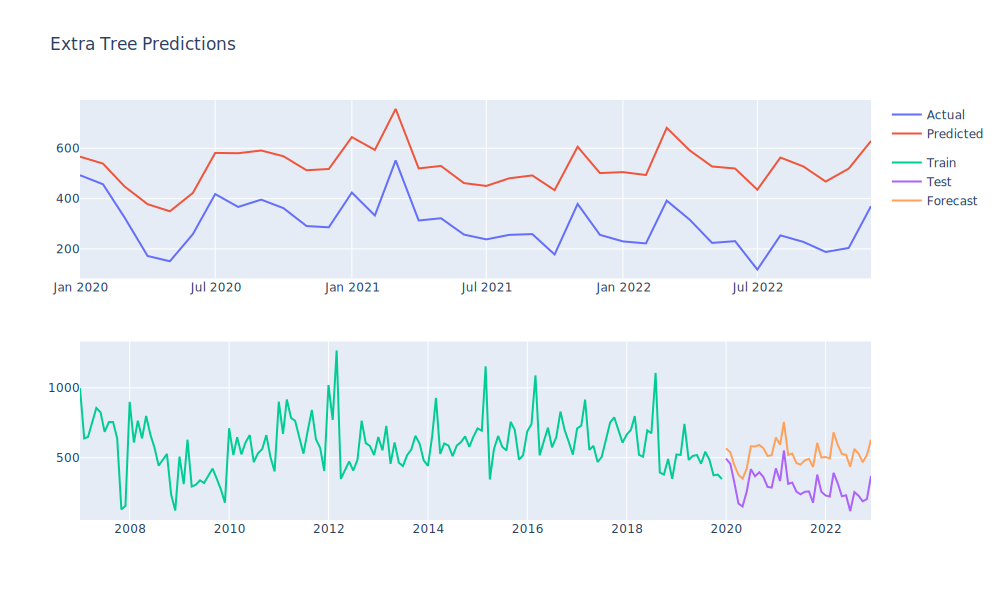

XGBoost Model Performance:
Mean Absolute Error: 208.02.
Mean Squared Error: 46708.66.
Root Mean Squared Error: 216.12.
R^2 Score = -3.88.
Mean Absolute Percentage Error: 81.78%.
Accuracy = 18.22%.


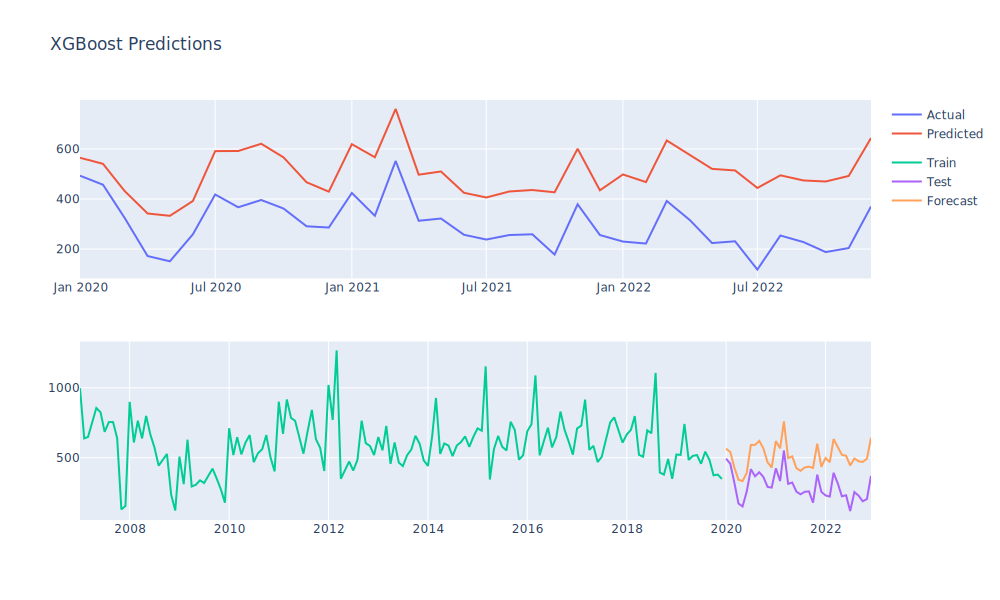

Gradient Boosting Model Performance:
Mean Absolute Error: 197.96.
Mean Squared Error: 43135.43.
Root Mean Squared Error: 207.69.
R^2 Score = -3.51.
Mean Absolute Percentage Error: 77.17%.
Accuracy = 22.83%.


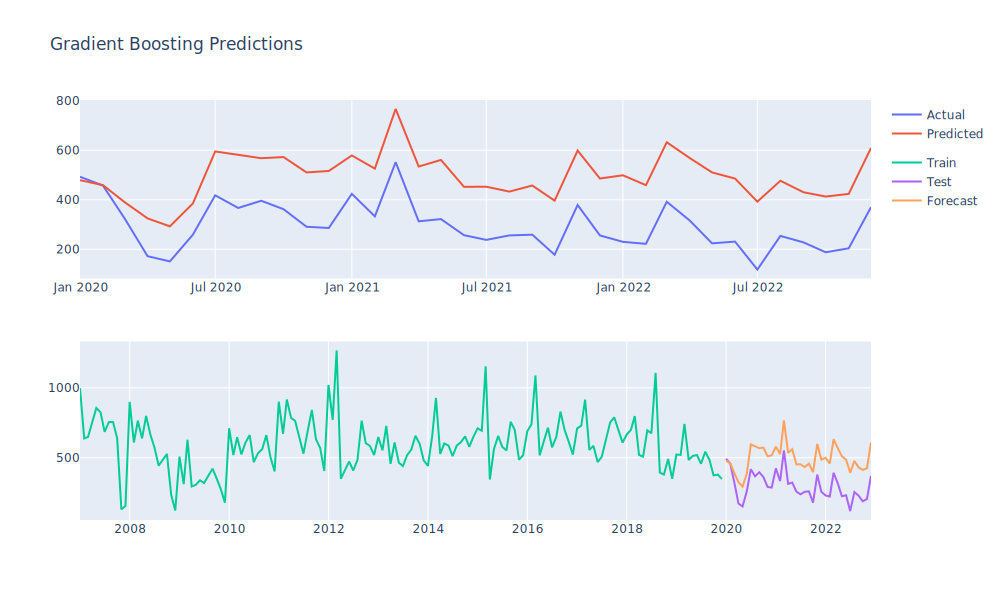

Random Forest Model Performance:
Mean Absolute Error: 233.82.
Mean Squared Error: 58539.11.
Root Mean Squared Error: 241.95.
R^2 Score = -5.11.
Mean Absolute Percentage Error: 91.01%.
Accuracy = 8.99%.


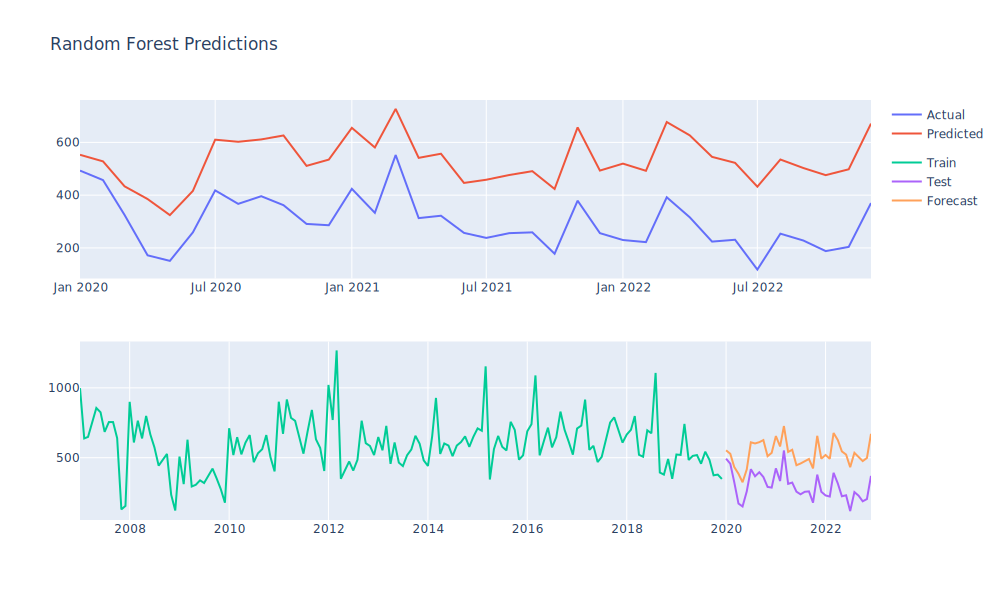

Ada Boost Model Performance:
Mean Absolute Error: 239.83.
Mean Squared Error: 61150.18.
Root Mean Squared Error: 247.29.
R^2 Score = -5.39.
Mean Absolute Percentage Error: 93.85%.
Accuracy = 6.15%.


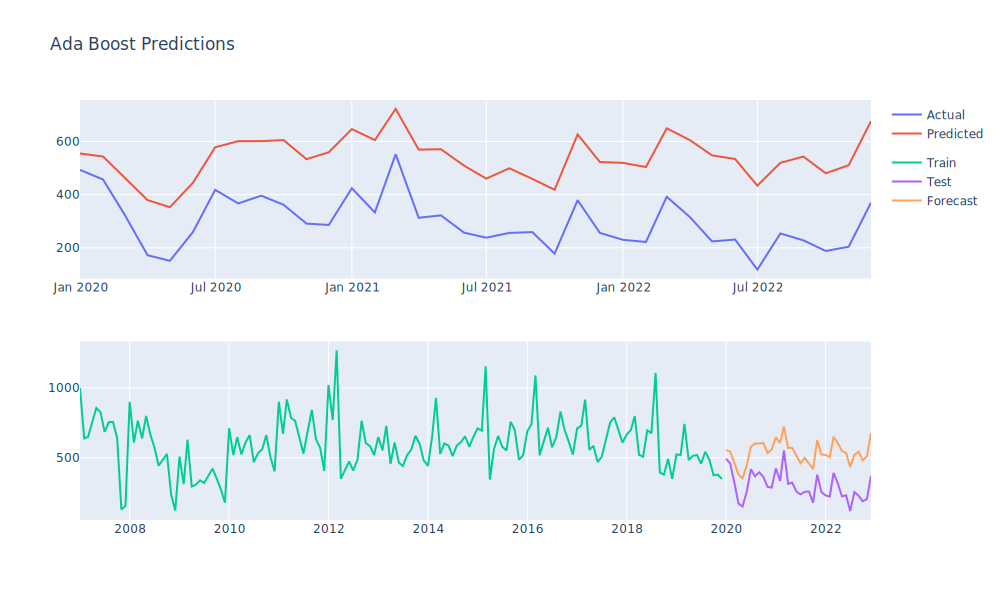

LightGBM Model Performance:
Mean Absolute Error: 148.27.
Mean Squared Error: 24755.71.
Root Mean Squared Error: 157.34.
R^2 Score = -1.59.
Mean Absolute Percentage Error: 58.24%.
Accuracy = 41.76%.


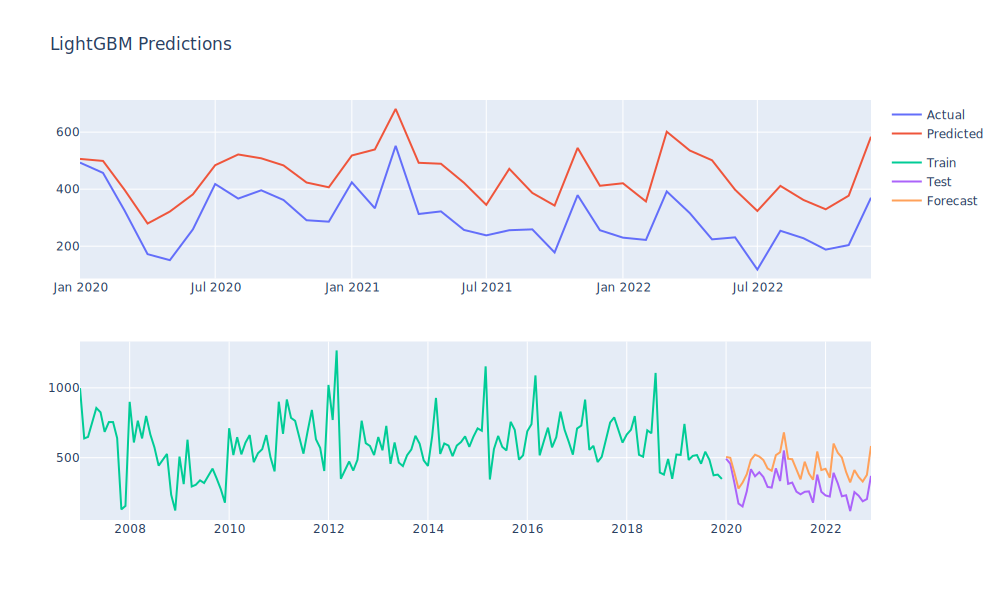

Decision Tree Model Performance:
Mean Absolute Error: 200.14.
Mean Squared Error: 48102.36.
Root Mean Squared Error: 219.32.
R^2 Score = -4.02.
Mean Absolute Percentage Error: 81.72%.
Accuracy = 18.28%.


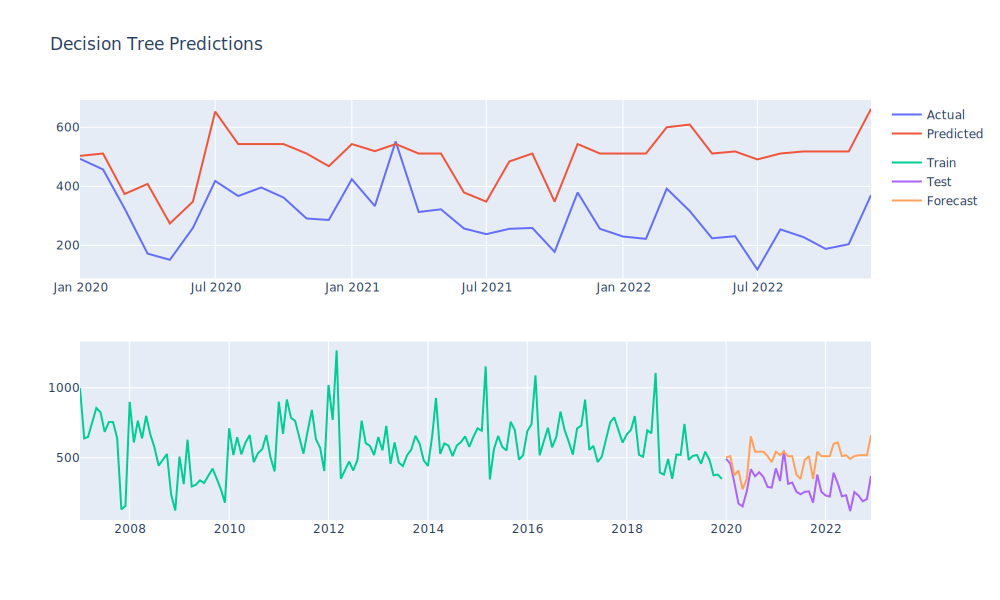

In [10]:
# Hyperparameters
#et_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]
et_params = [{}]
xgb_params = [{}]
gb_params = [{}]
rf_params = [{}]
ab_params = [{}]
lgbm_params = [{}]
dt_params = [{}]

modelclasses = [
    ["Extra Tree", ExtraTreesRegressor, et_params],
    ["XGBoost", XGBRegressor, xgb_params],
    ["Gradient Boosting", GradientBoostingRegressor, gb_params],
    ["Random Forest", RandomForestRegressor, rf_params],
    ["Ada Boost", AdaBoostRegressor, ab_params],
    ["LightGBM", LGBMRegressor, lgbm_params],
    ["Decision Tree", DecisionTreeRegressor, dt_params]
]

number_of_lags = 12

for model_name, Model, params_list in modelclasses:
    for params in params_list:

        # Create forecaster
        forecaster = ForecasterAutoreg(
                regressor = Model(**params),
                lags = number_of_lags
        )
        # Fit model
        forecaster.fit(y=train[dep_var], exog=train_exo)
        
        # Predict
        preds = forecaster.predict(steps=steps, exog=test_exo)

        # Score
        scoring(model_name, test[dep_var], preds, True, True)

In [11]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree
Mean Absolute Error,229.682500,208.023033,197.962495,233.818889,239.826554,148.271213,200.138889
Mean Squared Error,56152.841108,46708.659730,43135.429488,58539.113389,61150.177808,24755.711066,48102.361111
Root Mean Squared Error,236.965907,216.121863,207.690706,241.948576,247.285620,157.339477,219.322505
R^2,-4.864805,-3.878421,-3.505220,-5.114036,-5.386745,-1.585576,-4.023984
Mean Absolute Percentage Error,90.271181,81.781675,77.173743,91.008688,93.853451,58.237573,81.716145
Accuracy,9.728819,18.218325,22.826257,8.991312,6.146549,41.762427,18.283855


### LightGBM

In [12]:
# Instantiate the regressor
model = LGBMRegressor()

# Create forecaster
best_forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(),
                lags      = number_of_lags
             )

# Train forecaster
best_forecaster.fit(y=train[dep_var], exog=train_exo)
best_forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Avg_Fuel_Price', 'CCI', 'CPI', 'Long_term_interest_rates', 'Orders_lagged_12m', 'Orders_rolled_detrended', 'TIV', 'TIV_rolled_detrended', 'Unemployment_rate'] 
Training range: [Timestamp('2007-01-01 00:00:00'), Timestamp('2019-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'si

#### Hyperparameter Tuning

In [13]:
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(),
                lags      = 12                  # This value is replaced in the gridsearch
             )

lags_grid = [3,6,12]

# Set hyperparameters possibilities for model tuning
lgbm_n_estimators = [10, 50, 100]
lgbm_max_depth = [4, 6, 8]
lgbm_num_leaves = [3, 5, 7]
lgbm_learning_rate = [0.01, 0.1, 0.3]
lgbm_subsample = [0.3, 0.2, 0.1]

# Create the grid
param_grid = {'n_estimators': lgbm_n_estimators,
            'max_depth': lgbm_max_depth,
            'num_leaves': lgbm_num_leaves,
            'learning_rate': lgbm_learning_rate,
            'subsample': lgbm_learning_rate
           }

grid_results = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train[dep_var],
                        exog               = train_exo,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

Number of models compared: 729.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:53<00:00, 17.98s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 5, 'subsample': 0.3}
  Backtesting metric: 7174.362268323877



In [14]:
# Grid Search Results
grid_results.head()

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators,num_leaves,subsample
617,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",7174.362268,0.1,6.0,100.0,5.0,0.30
615,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",7174.362268,0.1,6.0,100.0,5.0,0.01
642,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",7174.362268,0.1,8.0,100.0,5.0,0.01
643,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",7174.362268,0.1,8.0,100.0,5.0,0.10
589,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",7174.362268,0.1,4.0,100.0,5.0,0.10


LGBMRegressor Tuned Model Performance:
Mean Absolute Error: 147.42.
Mean Squared Error: 24603.11.
Root Mean Squared Error: 156.85.
R^2 Score = -1.57.
Mean Absolute Percentage Error: 58.04%.
Accuracy = 41.96%.


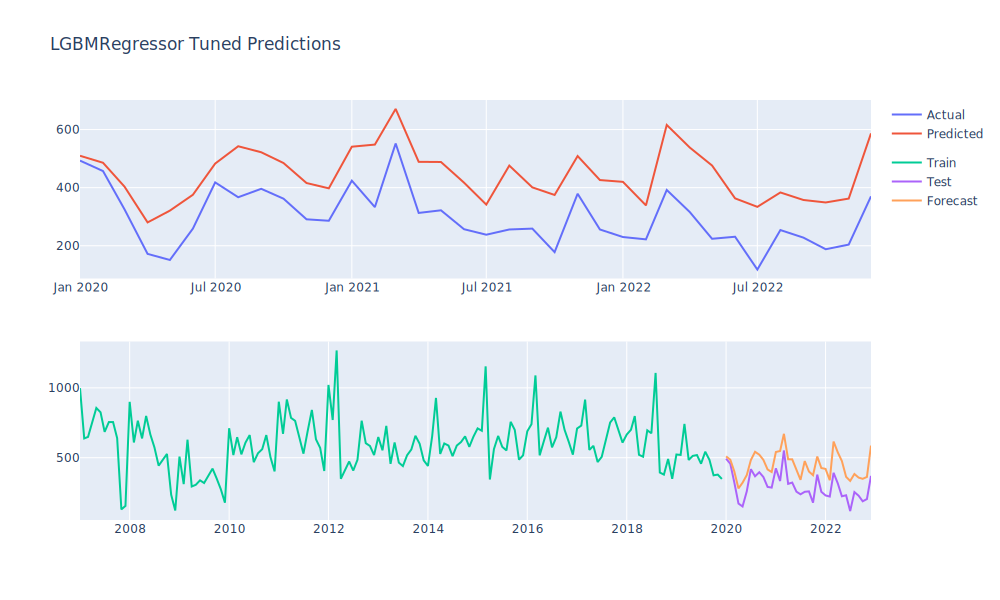

In [15]:
# Predict and score
model_name = model.__class__.__name__ + ' Tuned'
preds = forecaster.predict(steps=steps, exog=test_exo)
scoring(model_name, test[dep_var], preds, True, True)

#### Backtesting

LGBMRegressor Tuned Backtesting:
Mean Absolute Error: 117.55.
Mean Squared Error: 21452.22.
Root Mean Squared Error: 146.47.
R^2 Score = 0.49.
Mean Absolute Percentage Error: 28.47%.
Accuracy = 71.53%.


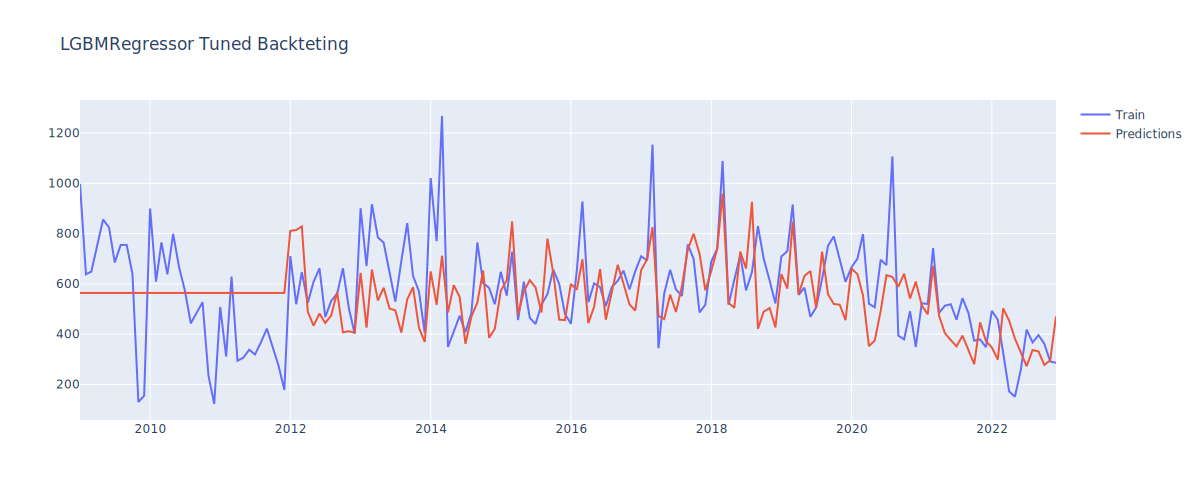

In [16]:
# Number of samples for backtest (14 y)
n_backtesting = 12*14

metric, backtest_pred = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df[dep_var],
                                    exog               = df_exo,
                                    initial_train_size = len(df) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
                                    verbose            = False
                                 )
         
# Calculate metrics
mae = metric[1]                                                                      # MAE (Mean Absolute Error)
mse = metric[0]                                                                      # MSE (Mean Squared Error)
rmse = math.sqrt(metric[0])                                                          # RMSE (Root Mean Squared Error)    
r2 = r2_score(df.loc[backtest_pred.index, dep_var].values, backtest_pred.pred)       # R2 (R-squared - Coeficient of determination)   
mape = metric[2] * 100                                                               # MAPE
accuracy = 100 - mape                                                                # Accuracy
    
# Print metrics
print(model_name, 'Backtesting:')                                   # Model name
print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(dict(x=backtest_pred.index, y=df[dep_var], mode='lines', name= 'Train')))
fig.add_trace(go.Scatter(dict(x=backtest_pred.index, y=backtest_pred.pred, mode='lines', name= 'Predictions')))
fig.update_layout(height=500, width=1200, title_text=model_name + " Backteting")    
fig.show()

#### Feature importance

In [17]:
# Feature importance
feature_importance = forecaster.get_feature_importance().sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
17,Orders_rolled_detrended,78
19,TIV_rolled_detrended,29
3,lag_4,24
0,lag_1,22
11,lag_12,22
8,lag_9,19
9,lag_10,19
1,lag_2,18
20,Unemployment_rate,18
6,lag_7,18


### Summary

In [18]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree,LGBMRegressor Tuned
Mean Absolute Error,229.682500,208.023033,197.962495,233.818889,239.826554,148.271213,200.138889,147.419470
Mean Squared Error,56152.841108,46708.659730,43135.429488,58539.113389,61150.177808,24755.711066,48102.361111,24603.113916
Root Mean Squared Error,236.965907,216.121863,207.690706,241.948576,247.285620,157.339477,219.322505,156.853798
R^2,-4.864805,-3.878421,-3.505220,-5.114036,-5.386745,-1.585576,-4.023984,-1.569638
Mean Absolute Percentage Error,90.271181,81.781675,77.173743,91.008688,93.853451,58.237573,81.716145,58.041924
Accuracy,9.728819,18.218325,22.826257,8.991312,6.146549,41.762427,18.283855,41.958076


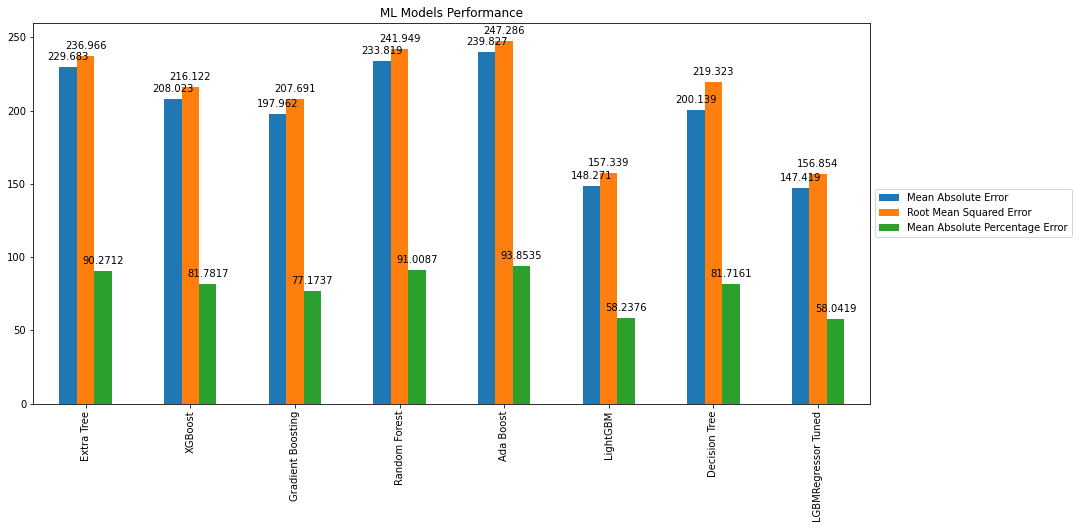

In [19]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="ML Models Performance", figsize=(15,7))
for container in ax.containers:
    ax.bar_label(container, padding=5)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))